# Импорт библиотек

In [1]:
# Загружаем библиотеки
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Подгружаем библиотеки для ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
import shap
import pickle

# Для корректного отображения графиков
%matplotlib inline

# Обучение моделей

Результаты ExtraTreesRegressor:
- Оптимальные параметры модели: {'max_features': 400, 'min_samples_leaf': 20, 'min_samples_split': 35, 'n_estimators': 250}
- R2_score - 0.95
- Наиболее важные признаки, влияющие на плотность: NumHeteroatoms, MolLogP, NumRotatableBonds и type DES. На плотность больше всего влияет тип соединений, а не условия проведения эксперимента и соотношения.

#### Функции для ML

In [26]:
# Выводит график весов, может потребоваться какое то время для выполнения
def feature_importance(model):
    explainer = shap.Explainer(model.predict, X_train, max_evals=1041)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, plot_type='bar')


# Сохраняет веса
def weights_model(name, model):
    if name.endswith('.pkl'):
        with open(name, 'wb') as f:
            pickle.dump(model, f)
    else:
        print('Неправильное название файла')


#### ExtraTreesRegressor

In [27]:
df = pd.read_csv('Final.csv')
df.drop(['Unnamed: 0', ], axis=1, inplace=True)

In [28]:
# Выбираем численные признаки
numeric_columns = df.select_dtypes(include='number').columns.tolist()

In [29]:
# Нормализуем датасет с помощью MinMaxScaller
to_scale_df = df[numeric_columns].copy()
scaled_data = preprocessing.MinMaxScaler().fit_transform(to_scale_df)
scaled_df = pd.DataFrame(scaled_data, columns=to_scale_df.columns)

In [30]:
# разделяем таргет и фичи
X_norm = scaled_df.drop('Density, g/cm^3', axis=1)
y_norm = scaled_df['Density, g/cm^3']

In [31]:
# Разделяем выборки на train и test
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm,
                                                    train_size=0.8,
                                                    random_state=666)

In [32]:
# обучаем ExtraTreesRegressor
model_xtra = ExtraTreesRegressor(n_estimators=170)

param_grid = {'n_estimators': range(100, 400, 50),
              'max_features': range(50, 401, 50),
              'min_samples_leaf': range(20, 50, 10),
              'min_samples_split': range(15, 36, 5),
              }

# Подбираем наилучшие параметры
# xtra_grid = GridSearchCV(model_xtra, param_grid, cv=5)
# xtra_grid.fit(X_train, y_train)
# best_params = xtra_grid.best_params_
# print(f'best grid search params: {best_params}')

# best grid search params: {'max_features': 400, 'min_samples_leaf': 20, 'min_samples_split': 35, 'n_estimators': 250}
best_params = {'max_features': 400, 'min_samples_leaf': 20, 'min_samples_split': 35, 'n_estimators': 250}

model_xtra = ExtraTreesRegressor(**best_params)
model_xtra.fit(X_train, y_train)
score_extra_tree = cross_val_score(model_xtra, X_train, y_train, cv=5)

print('Cross validation scores: ', score_extra_tree)
print('Mean Score: ', score_extra_tree.mean())

Cross validation scores:  [0.95179957 0.9266673  0.94125563 0.90885223 0.93332901]
Mean Score:  0.932380745787151


In [33]:
# Отнормализуем обратно X_test для прогноза
min_val = df['Density, g/cm^3'].min()
max_val = df['Density, g/cm^3'].max()
y_true = y_test * (max_val - min_val) + min_val
y_pred = model_xtra.predict(X_test) * (max_val - min_val) + min_val

In [34]:
# Проверим r2 score для тестовых данных
print("R2-score: %.2f" % r2_score(y_true, y_pred))
# Проверим mse score для тестовых данных
mse = mean_squared_error(y_true, y_pred)
print("MSE: %.4f" % mse)
print('RMSE: %.4f' % np.sqrt(mse) )

R2-score: 0.95
MSE: 0.0011
RMSE: 0.0327


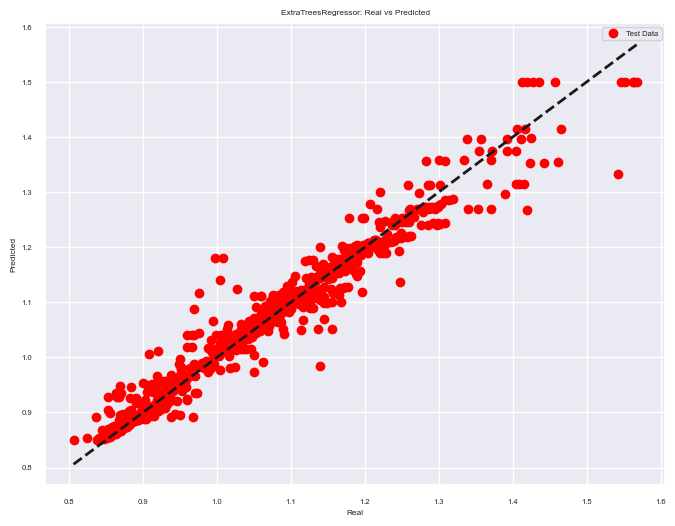

In [35]:
# Построим график сравнения y_test y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='red', label='Test Data')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('ExtraTreesRegressor: Real vs Predicted')
plt.legend()
plt.show()

In [36]:
# weights_model('model_xtra.pkl', model_xtra)

PermutationExplainer explainer: 759it [14:54,  1.18s/it]                         


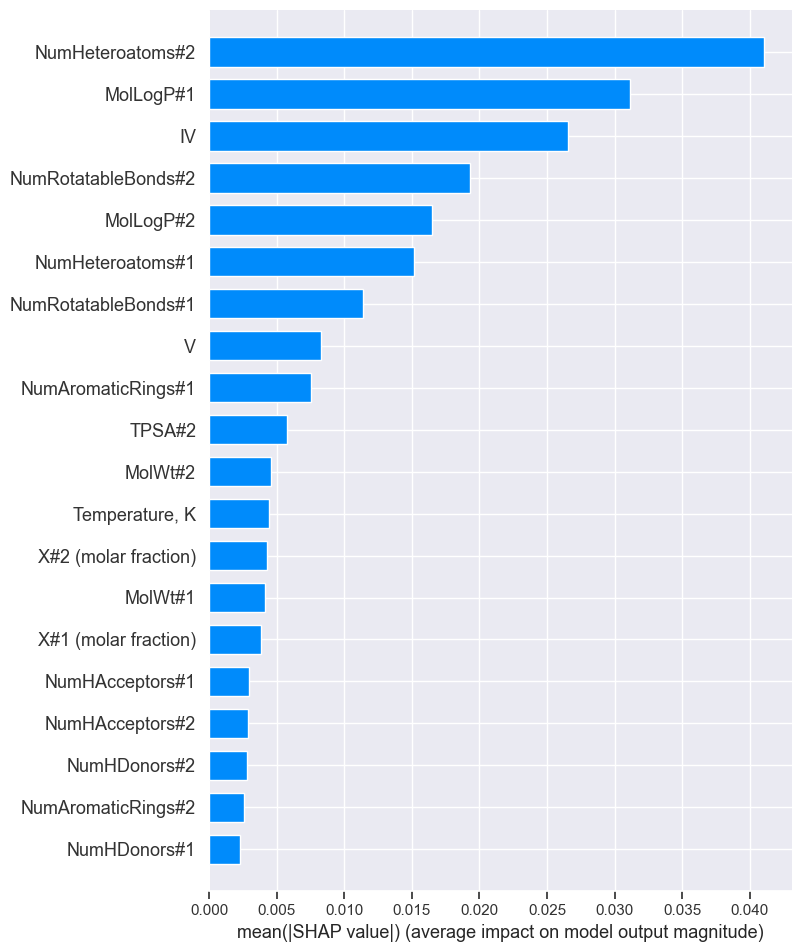

In [37]:
# feature_importance(model_xtra)